In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import regex as re
import numpy as np

from read_1t1r_data import read_1t1r_data

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
# plt.style.use('dracula')
# plt.style.use('ggplot')

print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'dracula', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [4]:
folder = '.'

test_types = ['Prog']
all_data = {}
for ttype in test_types:
    # recursively search the folder for excel files starting with ttype
    t, d,l = read_1t1r_data(folder, ttype)

    # sort the data by temerature and store it
    all_data[ttype] = sorted(list(zip(t,d,l)), key=lambda x:x[0])
    
    print(f"Found {len(d)} {ttype} Tests across {len(np.unique(t))} temperatures")

Found 29 Prog Tests across 1 temperatures


In [5]:
all_data['Prog'][1][1][:,9]

# len(all_data['Prog'][0][1])

array([1.12618e-07, 1.23546e-07, 1.26508e-07, ..., 1.58785e-04,
       1.59740e-04, 1.61291e-04])

In [9]:
#2D lists

#LRS HRS SETV RESETV GATEV VREAD LRSREADI HRSREADI SETI RESETI
#15 total prog excel files 
#total 2000 - 13 files
#total 1000 - 2 files

#vread = -0.2
#setv = 1.2
#resetv = -1.2

#gatev =[]      ##5 
#LRSreadi =[]   ##7
#HRSreadi =[]   ##8
#seti =[]       ##9
#reseti =[]     ##10

def test_singledevice(d,t, x_single, LRS_res, LRS_x, LRS_res_final, LRS_x_final, n_samples):
    #LRS_gatevs = []
    #LRS_single = []        #1
    #HRS_single = []        #2
    

    avg_resistance = []
    avg_x = []
    sample=0
    final_idx = 0

    if len(d[1]) != 2000:
        return "not equal to 2000"
    res_single = d[1][:,1] 
    x_single = d[1][:,t]

    for i in range(0,200,1):
        lrs_res = []
        lrs_x = []
        for j in range(10):
            lrs_res.append(res_single[200*j+i])
            lrs_x.append(x_single[200*j+i])
        LRS_res[i] += lrs_res
        LRS_x[i] += lrs_x
    

    for (i, res), x in zip(enumerate(LRS_res),LRS_x) : #list of res
        avg_resistance += res
        avg_x += x
        sample += 1

        if sample == n_samples:
            LRS_res_final[final_idx] += avg_resistance
            LRS_x_final[final_idx] += avg_x
            final_idx+=1
            sample = 0
            avg_resistance=[]
            avg_x=[]



def plot(t):
    LRS_res = []
    LRS_x = []
    LRS_res_final = []
    LRS_x_final = []

    for i in range(0,200,1):
        LRS_res.append([])
        LRS_x.append([])


    n_samples=8
    for i in range(0,int(200/n_samples),1):
        LRS_res_final.append([])
        LRS_x_final.append([])

    x_single = []
    
    for i in range(len(all_data['Prog'])):
        test_singledevice(all_data['Prog'][i],t,  x_single, LRS_res, LRS_x, LRS_res_final, LRS_x_final, n_samples)

    # print(len(gatevs_single))
    # print(len(LRS_gatevs))
    LRS_x_final = np.average(LRS_x_final,1)
    fig = plt.subplots(1,1,figsize=(8,5),dpi=600)
    if t == 5:
        print(len(np.arange(0.5, 1.25, 0.05)))
        print(len(LRS_res_final))
        # plt.boxplot(LRS_res_final,showfliers= False,widths=0.015,positions=np.arange(0.5, 1.25, 0.05))
        plt.boxplot(LRS_res_final,showfliers= False,widths=0.015,positions=np.round(LRS_x_final,4))
        plt.xlabel('Voltage (V)')
        plt.xlim(0.75,1.25)
    if t == 9:
        w = 10.25
        width = lambda p, w: 10**(np.log10(p)+w/2.)-10**(np.log10(p)-w/2.)
        plt.boxplot(LRS_res_final,showfliers= False,widths=width(LRS_x_final, w),positions=1e6*LRS_x_final)
        plt.xscale("log")
        plt.xlabel('Current (uA)')
        #plt.xlim(0.122,161)
    plt.yscale("log")
    plt.ylabel(r'Resistance ($\Omega$)')
    plt.xticks(
        rotation=45, 
        horizontalalignment='right',
        fontweight='light',
        fontsize='small'  
    )
    
    #plt.ylim(0,25000)
    plt.savefig('res_vs_vnset.pdf', bbox_inches='tight')
    plt.show()



    # gatevs = []

    # for idx, d in enumerate(all_data['Prog']):
    #     if len(d[1]) != 2000:
    #         continue 
    #     LRS.append(d[1][:,1])
    #     HRS.append(d[1][:,2])
    #     gatevs.append(d[1][:,t]) #gate voltage used during set/reset

    # #print(np.mean(LRS))
    # # print(np.mean(HRS))

    # #print(gatevs[0:2])
    # np.unique(len(gatevs))



15
25


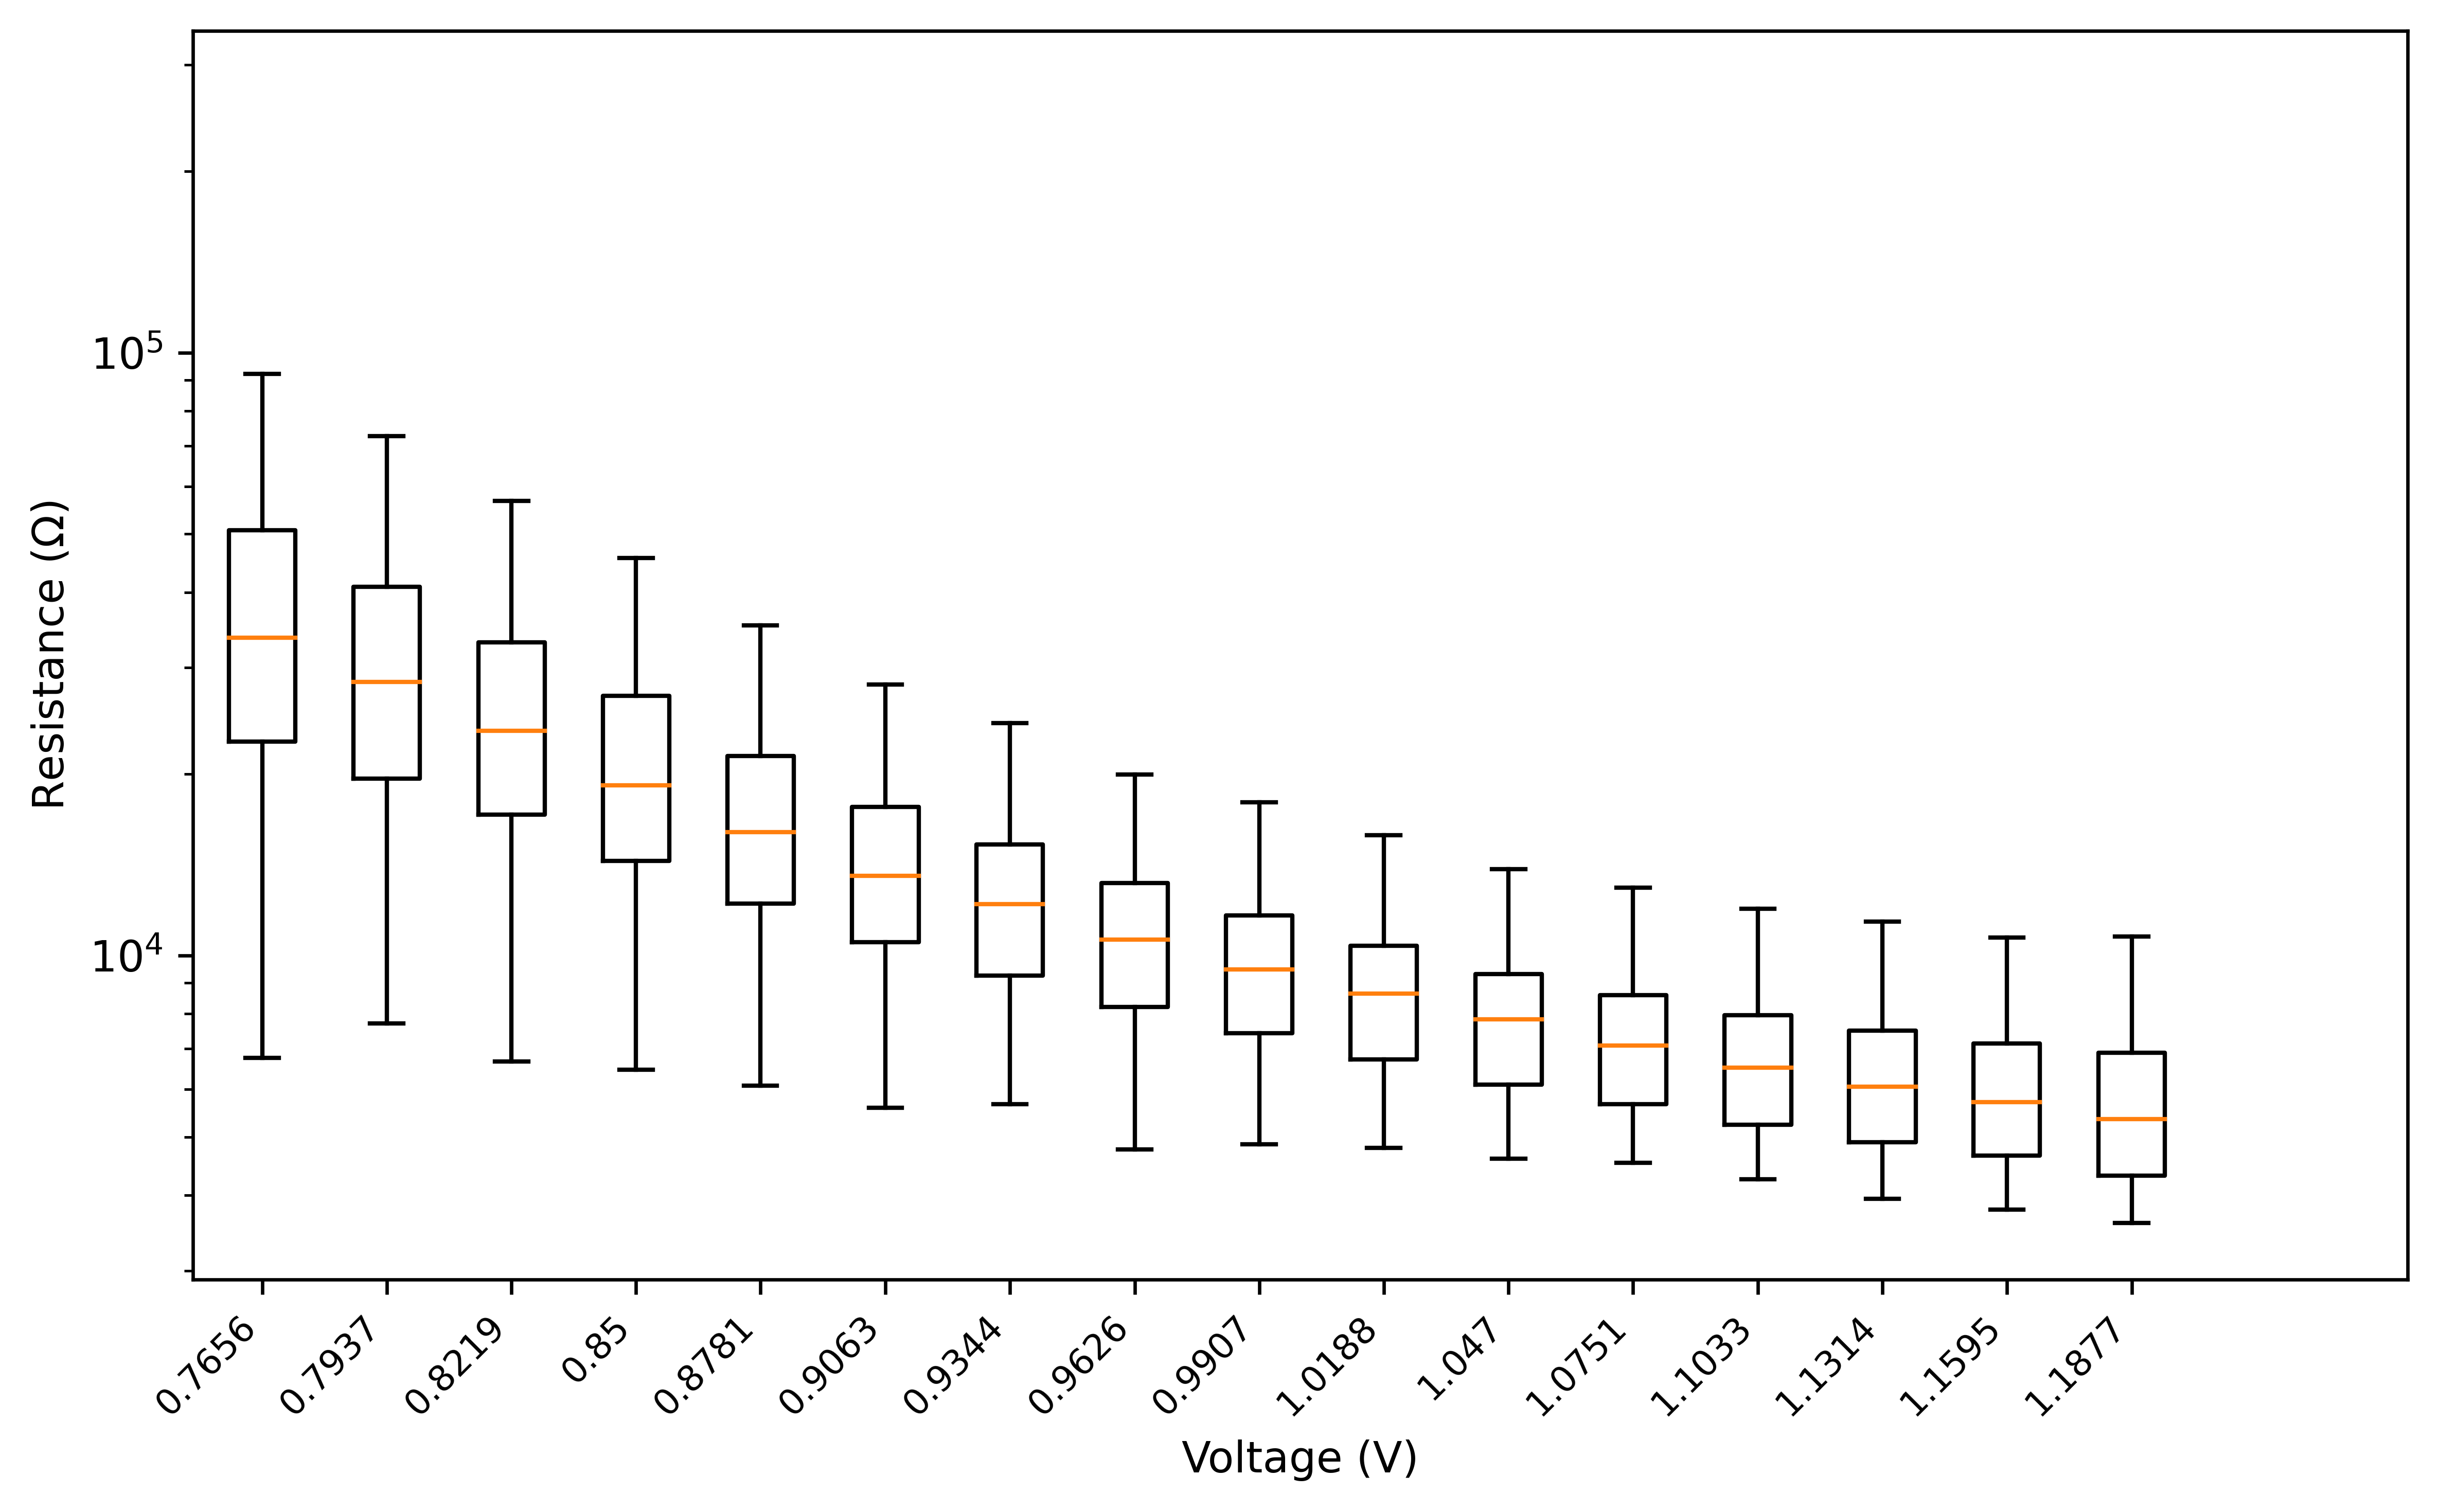

In [10]:
plot(5)
# plot(9)

In [8]:
# len(np.average(LRS_x_final,1))